# API

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import matplotlib.pyplot as plt
import time
import pickle
from copy import copy
# %load_ext line_profiler

In [3]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [8]:
# ipcluster start --engines=MPI -n 4
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from pSC import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [7]:
# %%writefile pSC.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib

class Params:
    def __init__(self,
            Lx=4,
            Ly=16,
            Delta=1,
            t=1,
            m=1,
            bcx=-1,
            bcy=1,
            T=0,
            dxmax=16,
            dymax=16,
            history=False,
            ):
        self.Lx = Lx
        self.Ly = Ly
        self.Delta = Delta
        self.t = t
        self.m = m
        self.bcx = bcx
        self.bcy = bcy
        self.T = T
        self.history = history
        self.sigmax = np.array([[0, 1], [1, 0]])
        self.sigmay = np.array([[0, -1j], [1j, 0]])
        self.sigmaz = np.array([[1, 0], [0, -1]])
        # check which one is faster, use sparse or dense?
        if Lx<np.inf and Ly<np.inf:
            hopx = np.diag(np.ones(Lx-1), -1)
            hopx[0, -1] = bcx
            hopy = np.diag(np.ones(Ly-1), -1)
            hopy[0, -1] = bcy
            hopxmat = np.kron( np.eye(Ly),hopx)
            hopymat = np.kron(hopy,np.eye(Lx))
            onsitemat = np.eye(Lx*Ly)
            self.Hamiltonian = ((np.kron(hopxmat-hopxmat.T, self.sigmax)+np.kron(hopymat-hopymat.T, self.sigmay))* 1j*Delta-t*np.kron(hopxmat+hopxmat.T+hopymat+hopymat.T, self.sigmaz))/2+m*np.kron(onsitemat, self.sigmaz)
        elif Lx==np.inf and Ly==np.inf:
            self.dxmax=dxmax
            self.dymax=dymax
            self.dx=lambda kx: Delta*np.sin(kx)
            self.dy=lambda ky: Delta*np.sin(ky)
            self.dz=lambda kx,ky: m-t*np.cos(kx)-t*np.cos(ky)
        else:
            raise ValueError('The size of system {:d,:d} is not supported.'.format(Lx,Ly))

    def bandstructure(self):
        val, vec = nla.eigh(self.Hamiltonian)
        sortindex = np.argsort(val)
        self.val = val[sortindex]
        self.vec = vec[:, sortindex]

    def fermi_dist_k(self,kx,ky,branch,E_F=0):
        if self.T==0:
            return np.heaviside(E_F-self.E_k(kx,ky,branch),0)
        else:
            return 1/(1+np.exp((self.E_k(kx,ky,branch)-E_F)/self.T))

    def fermi_dist(self, energy, E_F):
        if self.T == 0:
            return np.heaviside(E_F-energy, 0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def correlation_matrix_inf_fft(self,threshold=[1024,512]):
        '''
        self.dxmax/self.dymax: the maximal distance in x/y direction (in terms of unit cell) 
        Directly call fft to evaluate the integral
        '''
        assert self.Lx==np.inf and self.Ly==np.inf, "Wire length should be inf"
        # cov_mat=[]
        Nxmax=max(2*self.dxmax,threshold[0])
        Nymax=max(2*self.dymax,threshold[1])
        if self.T>0:
            pass    #to be filled
        else:
            kxlist=np.arange(0,2*np.pi,2*np.pi/Nxmax)
            kylist=np.arange(0,2*np.pi,2*np.pi/Nymax)
            kxmap,kymap=np.meshgrid(kxlist,kylist)
            dxmap=self.dx(kxmap)
            dymap=self.dy(kymap)
            dzmap=self.dz(kxmap,kymap)
            Ekmap=np.sqrt(dxmap**2+dymap**2+dzmap**2)
            Ekxymap=np.sqrt(dxmap**2+dymap**2)
            costheta=dzmap/Ekmap
            sintheta=Ekxymap/Ekmap
            Ekxymap[0,0]=np.inf #to avoid 0/0 in cos(phi) & sin(phi); the order of this line matters
            cosphi=dxmap/Ekxymap
            sinphi=dymap/Ekxymap
            fftcostheta=np.fft.ifft2(costheta)
            constmap=np.zeros((Nymax,Nxmax))
            constmap[0,0]=0.5
            A_11=constmap-fftcostheta/2
            A_22=constmap+fftcostheta/2
            A_12=np.fft.ifft2(-(cosphi-1j*sinphi)/2*sintheta)
            A_21=np.fft.ifft2(-(cosphi+1j*sinphi)/2*sintheta)
            mat=np.stack([[A_11,A_12],[A_21,A_22]])
            C_f=np.zeros((2*self.dxmax*self.dymax,2*self.dxmax*self.dymax))*1j
            for i in range(self.dxmax*self.dymax):
                for j in range(i):
                    ix,iy=i%self.dxmax,i//self.dxmax
                    jx,jy=j%self.dxmax,j//self.dxmax
                    dx,dy=(ix-jx)%Nxmax,(iy-jy)%Nymax
                    C_f[2*i:2*i+2,2*j:2*j+2]=mat[:,:,dy,dx]
            C_f=C_f+C_f.T.conj()
            for i in range(self.dxmax*self.dymax):
                C_f[2*i:2*i+2,2*i:2*i+2]=mat[:,:,0,0]
            self.C_f=C_f


    def correlation_matrix(self, E_F=0):
        '''
        
        '''
        if not (hasattr(self, 'val') and hasattr(self, 'vec')):
            self.bandstructure()
        occupancy_mat = np.matlib.repmat(self.fermi_dist(self.val, E_F), self.vec.shape[0], 1)
        self.C_f=((occupancy_mat*self.vec)@self.vec.T.conj())
        
    def covariance_matrix(self, E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self, 'C_f'):
            if self.Lx < np.inf and self.Ly<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        # G=self.C_f[::2,::2]
        # F=self.C_f[::2,1::2]
        G=self.C_f[1::2,1::2]
        F=self.C_f[1::2,::2]
        self.G,self.F=G,F
        Gamma_11 = 1j*(F.conj().T+F+G-G.T)
        Gamma_21 = -(np.eye(G.shape[0])+F.conj().T-F-G-G.T)
        Gamma_12 = -Gamma_21.T
        Gamma_22 = -1j*(F.conj().T+F+G.T-G)
        Gamma = np.zeros((2*G.shape[0], 2*G.shape[0]), dtype=complex)
        even = np.arange(2*G.shape[0])[::2]
        odd = np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even, even)] = Gamma_11
        Gamma[np.ix_(even, odd)] = Gamma_12
        Gamma[np.ix_(odd, even)] = Gamma_21
        Gamma[np.ix_(odd, odd)] = Gamma_22
        assert np.abs(np.imag(Gamma)).max() < 1e-10, "Covariance matrix not real {:.5f}".format(np.abs(np.imag(Gamma)).max())
        self.C_m = np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history = [self.C_m]

    def linearize_index(self, subregion, n, proj=False):
        '''
        If proj ==True, then the index used for projection operator will be returned
        '''
        subregion_x, subregion_y = (subregion)
        subregion_x = np.array(subregion_x)
        subregion_y = np.array(subregion_y)
        X, Y = np.meshgrid(subregion_x, subregion_y)
        if self.Ly<np.inf:
            assert subregion_x.max()<self.Lx and subregion_y.max()<self.Ly, '({:d},{:d}) exceed ({:d},{:d})'.format(subregion_x.max(),self.Lx,subregion_y.max(),self.Ly)
            linear_index = ((X+Y*self.Lx).flatten('F'))
        else:
            assert subregion_x.max()<self.dxmax and subregion_y.max()<self.dymax, '({:f},{:f}) exceed ({:f},{:f})'.format(subregion_x.max(),(self.dxmax),subregion_y.max(),(self.dymax))
            linear_index = ((X+Y*self.dxmax).flatten('F'))
        if proj:
            return sorted(np.concatenate([n*linear_index+i for i in range(0, n, 2)]))
        else:
            return sorted(np.concatenate([n*linear_index+i for i in range(n)]))

    def square_index(self, subregion):
        subregion=np.unique(np.array(subregion)//2)
        if self.Lx<np.inf and self.Ly<np.inf:
            return subregion%self.Lx,subregion//self.Lx
        else:
            return subregion%self.dxmax,subregion//self.dxmax
            
    def c_subregion_f(self, subregion, linear=True):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_f'):
            self.correlation_matrix()
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 2)
        # This is a dumb way...
        return self.C_f[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_f(self, subregion):
        c_A = self.c_subregion_f(subregion)
        val = nla.eigvalsh(c_A)
        self.val_sh = val
        val = np.sort(val)
        val=np.sort(val)[:val.shape[0]//2]
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self, subregion, Gamma=None):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma = self.C_m_history[-1]
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 2)

        return Gamma[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_m(self, subregion):
        c_A = self.c_subregion_m(subregion)
        val = nla.eigvalsh(1j*c_A)
        self.val_sh = val
        val = np.sort(val)
        val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 2)
        subregion_B = self.linearize_index(subregion_B, 2)
        s_A = self.von_Neumann_entropy_f(subregion_A)
        s_B = self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self, subregion_A, subregion_B,linear=False):
        if not linear:
            subregion_A = self.linearize_index(subregion_A, 2)
            subregion_B = self.linearize_index(subregion_B, 2)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB  

    def log_neg(self, subregion_A, subregion_B, Gamma=None,linear=False):
        if not linear:
            subregion_A = self.linearize_index(subregion_A, 2)
            subregion_B = self.linearize_index(subregion_B, 2)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()

        if Gamma is None:
            Gamma = self.C_m_history[-1]
        subregion_A = np.array(subregion_A)
        subregion_B = np.array(subregion_B)
        Gm_p = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], 1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        Gm_n = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], -1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [-1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        idm = np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x = idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p), (idm+1j*Gm_n)))
        Gm_x = (Gm_x+Gm_x.T.conj())/2
        xi = nla.eigvalsh(Gm_x)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        eA = np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi = nla.eigvalsh(1j*Gamma[np.ix_(subregion_AB, subregion_AB)])
        sA = np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        self.eA=eA
        self.sA=sA
        return np.real(eA+sA)

    def projection(self, s):
        '''
        For type:'onsite'
            occupancy number: s= 0,1 
            (-1)^0 even parity, (-1)^1 odd parity
        '''
        assert (s == 0 or s == 1), "s={} is either 0 or 1".format(s)
        blkmat = np.array([[0, -(-1)**s, 0, 0],
                           [(-1)**s, 0, 0, 0],
                           [0, 0, 0, (-1)**s],
                           [0, 0, -(-1)**s, 0]])
        return blkmat

    def measure(self, s, ix):
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if not hasattr(self, 's_history'):
            self.s_history = []
        if not hasattr(self, 'i_history'):
            self.i_history = []

        mat = self.C_m_history[-1].copy()

        for i_ind, i in enumerate(ix):
            mat[[i, -(len(ix)-i_ind)]] = mat[[-(len(ix)-i_ind), i]]
            mat[:, [i, -(len(ix)-i_ind)]] = mat[:, [-(len(ix)-i_ind), i]]

        self.mat = mat

        Gamma_LL = mat[:-len(ix), :-len(ix)]
        Gamma_LR = mat[:-len(ix), -len(ix):]
        Gamma_RR = mat[-len(ix):, -len(ix):]

        proj = self.projection(s)
        Upsilon_LL = proj[:-len(ix), :-len(ix)]
        Upsilon_RR = proj[-len(ix):, -len(ix):]
        Upsilon_RL = proj[-len(ix):, :-len(ix)]
        zero = np.zeros((mat.shape[0]-len(ix), len(ix)))
        zero0 = np.zeros((len(ix), len(ix)))
        mat1 = np.block([[Gamma_LL, zero], [zero.T, Upsilon_RR]])
        mat2 = np.block([[Gamma_LR, zero], [zero0, Upsilon_RL]])
        mat3 = np.block([[Gamma_RR, np.eye(len(ix))],
                        [-np.eye(len(ix)), Upsilon_LL]])
        self.mat2 = mat2
        if np.count_nonzero(mat2):
            Psi = mat1+mat2@(la.solve(mat3, mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(
                np.trace(Psi)) < 1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi = mat1

        for i_ind, i in enumerate(ix):
            Psi[[i, -(len(ix)-i_ind)]] = Psi[[-(len(ix)-i_ind), i]]
            Psi[:, [i, -(len(ix)-i_ind)]] = Psi[:, [-(len(ix)-i_ind), i]]
        Psi = (Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(ix[0])
        else:
            self.C_m_history = [Psi]
            self.s_history = [s]
            self.i_history = [ix[0]]

    def measure_all_Born(self, proj_range,prob=None,linear=False):
        if not linear:
            proj_range = self.linearize_index(proj_range, 2, proj=True)
        self.proj_range=proj_range
        # print(proj_range)
        self.P_0_list = []
        self.f_parity= []
        self.covariance_matrix()
        for i in proj_range:
            if prob is None:
                P_0 = (self.C_m_history[-1][i, i+1]+1)/2    # Use Born rule
            else:
                P_0=prob
            self.P_0_list.append(P_0)
            if np.random.rand() < P_0:
                self.measure(0, [i, i+1])
                self.f_parity.append(0)
            else:
                self.measure(1, [i, i+1])
                self.f_parity.append(1)
        return self

def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta


In [50]:
params=Params(m=1,Lx=32,Ly=4,bcx=-1,bcy=1,history=True)
params.covariance_matrix()
zz1=params.C_f[0,params.linearize_index([np.arange(params.Lx),[0]],2)[::2]]

In [51]:
params=Params(m=1,Lx=32,Ly=8,bcx=-1,bcy=1,history=True)
params.covariance_matrix()
zz2=params.C_f[0,params.linearize_index([np.arange(params.Lx),[0]],2)[::2]]

In [30]:
params_inf=Params(m=1,dxmax=16,dymax=16,Lx=np.inf,Ly=np.inf,bcx=-1,bcy=1,history=True)
params_inf.covariance_matrix()

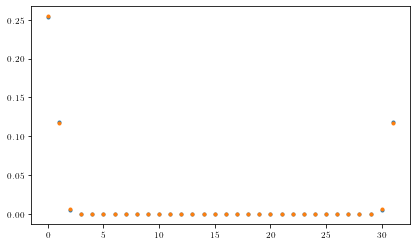

In [52]:
plt.plot(np.abs(zz1),'.')
plt.plot(np.abs(zz2),'.')

In [83]:
params_inf.C_f[0,:].shape

(512,)

In [73]:
params.C_f[2:4,:2]

array([[ 1.16747890e-01+3.24209454e-17j,  9.71445147e-17-1.66491187e-01j],
       [-2.17744059e-17-1.66491187e-01j, -1.16747890e-01-1.41379963e-16j]])

In [102]:
zz=params_inf.C_f[0,params_inf.linearize_index([np.arange(params_inf.dxmax),[0]],2)[1::2]]

In [103]:
zz

array([-5.20434225e-19+1.71758160e-18j,  2.01973446e-17+1.66490915e-01j,
        5.55987354e-18+2.29358053e-02j,  1.97159191e-18+6.58889661e-03j,
        8.47161101e-19+2.30386878e-03j,  3.04500452e-19+8.84256162e-04j,
       -7.46377962e-19+3.58455841e-04j,  1.48020639e-19+1.50631198e-04j,
        2.35106837e-19+6.49317689e-05j, -2.63734320e-19+2.85262532e-05j,
        4.58745006e-19+1.27178477e-05j,  2.95567587e-19+5.73676539e-06j,
        7.77563278e-20+2.61256184e-06j,  4.26179263e-19+1.19925355e-06j,
        7.76457392e-19+5.54195478e-07j, -1.34701264e-24+2.57573684e-07j,
        5.80686508e-20+1.20306937e-07j,  3.46964613e-19+5.64362655e-08j,
       -1.65883914e-19+2.65754464e-08j,  6.57167370e-20+1.25565840e-08j,
        5.94789075e-20+5.95079086e-09j, -5.93012402e-19+2.82785664e-09j,
       -4.44356535e-19+1.34711922e-09j, -3.12819200e-19+6.43165381e-10j,
       -7.72568602e-20+3.07696258e-10j,  5.41529068e-20+1.47479058e-10j,
       -1.14138994e-19+7.08079054e-11j,  3.66420427

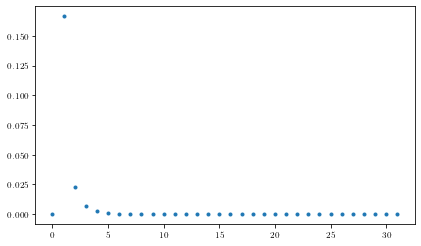

In [104]:
plt.plot(np.abs(zz),'.')

In [141]:
np.round(np.real(params.C_m),2)

array([[ 0.  , -0.49, -0.33, ..., -0.03, -0.06, -0.18],
       [ 0.49,  0.  , -0.23, ..., -0.01,  0.06,  0.06],
       [ 0.33,  0.23,  0.  , ..., -0.01,  0.01, -0.03],
       ...,
       [ 0.03,  0.01,  0.01, ...,  0.  , -0.23,  0.33],
       [ 0.06, -0.06, -0.01, ...,  0.23,  0.  , -0.49],
       [ 0.18, -0.06,  0.03, ..., -0.33,  0.49,  0.  ]])

In [142]:
Gmat_real=np.loadtxt('Gmat_real.txt')
Gmat_imag=np.loadtxt('Gmat_imag.txt')

In [144]:
np.abs(Gmat_real+1j*Gmat_imag-params.C_m).max()

4.775174699842074e-15

In [53]:
(np.round(np.real(params.C_m[:4,:4]),2))

array([[ 0.  , -0.93, -0.16,  0.02],
       [ 0.93,  0.  , -0.02,  0.16],
       [ 0.16,  0.02,  0.  , -0.93],
       [-0.02, -0.16,  0.93,  0.  ]])

In [42]:
np.real(params.Hamiltonian)

array([[ 1.,  0., -1.,  0.,  0., -1.,  0.,  0.],
       [ 0., -1.,  0.,  1.,  1.,  0.,  0.,  0.],
       [-1.,  0.,  1.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  1.,  0., -1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  1.,  0., -1.,  0.],
       [-1.,  0.,  0.,  0.,  0., -1.,  0.,  1.],
       [ 0.,  0.,  0.,  1., -1.,  0.,  1.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  1.,  0., -1.]])

In [8]:
params=Params(m=1,Lx=128,Ly=8,bcx=-1,bcy=1)

In [9]:
total=params.linearize_index([np.arange(params.Lx),np.arange(params.Ly)],2)
subA=params.linearize_index([np.arange(params.Lx//4),np.arange(params.Ly)],2)
proj_range=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],2,proj=True)
subB=params.linearize_index([np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)],2)


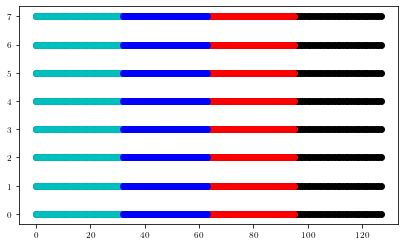

In [10]:
plt.scatter(*params.square_index(total),color='k')
plt.scatter(*params.square_index(subA),color='c')
plt.scatter(*params.square_index(subB),color='r')
plt.scatter(*params.square_index(proj_range),color='b')

In [151]:
params.measure_all_Born(proj_range,linear=True)

In [ ]:
params.i_history

In [153]:
params.log_neg(subA,subB,linear=True)

0.9701903382986599

In [154]:
params.C_m_history[-1][proj_range[0]:proj_range[0]+4,proj_range[0]:proj_range[0]+4]

array([[ 0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  1.,  0.]])

In [ ]:
params.s_history

In [ ]:
params.P_0_list

# No measurement-finite

In [35]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,40))
# m_list=(np.linspace(1,3,10))
Lx,Ly=128,4
LN_no_list=[]
MI_no_list=[]
for m in m_list:
    params=Params(m=m,Lx=Lx,Ly=Ly)
    MI_no_list.append(params.mutual_information_m(subA,subB,linear=True))
    LN_no_list.append(params.log_neg(subA,subB,linear=True))


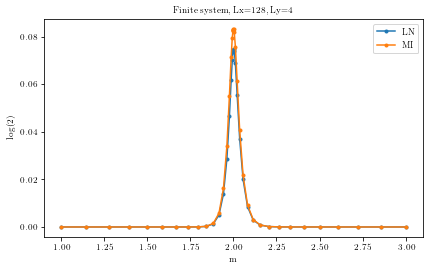

In [36]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_list/np.log(2),'.-',label='LN')
ax.plot(m_list,MI_no_list/np.log(2),'.-',label='MI')
ax.legend()
ax.set_xlabel('m')
ax.set_ylabel('log(2)')
ax.set_title('Finite system, Lx={:d}, Ly={:d}'.format(Lx,Ly))

fig.savefig('/mnt/d/kitp/Rp_SPT/9/LN_pSC_no_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

# No measurement-infinite

In [33]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,40))
# m_list=(np.linspace(1,3,10))
Lx,Ly=128,4
LN_no_inf_list=[]
MI_no_inf_list=[]
for m in m_list:
    params=Params(m=m,dxmax=Lx,dymax=Ly,Lx=np.inf,Ly=np.inf)
    MI_no_inf_list.append(params.mutual_information_m(subA,subB,linear=True))
    LN_no_inf_list.append(params.log_neg(subA,subB,linear=True))


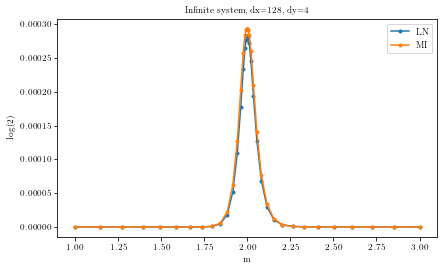

In [34]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_inf_list/np.log(2),'.-',label='LN')
ax.plot(m_list,MI_no_inf_list/np.log(2),'.-',label='MI')
ax.legend()
ax.set_xlabel('m')
ax.set_ylabel('log(2)')
ax.set_title('Infinite system, dx={:d}, dy={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/kitp/Rp_SPT/9/LN_pSC_no_inf_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

# Onsite measurement

In [12]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=(np.linspace(1,3,10))
es=20
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))
Lx,Ly=128,16

def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    total=params.linearize_index([np.arange(params.Lx),np.arange(params.Ly)],2)
    subA=params.linearize_index([np.arange(params.Lx//4),np.arange(params.Ly)],2)
    proj_range=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],2,proj=True)
    subB=params.linearize_index([np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)],2)

    params.measure_all_Born(proj_range,linear=True)
    LN=params.log_neg(subA,subB,linear=True)
    MI=params.mutual_information_m(subA,subB,linear=True)
    return MI,LN

for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born(proj_range,linear=True)
    #     MI_Born_list[m_i,es_i]=params.mutual_information_m(subA,subB,linear=True)
    #     LN_Born_list[m_i,es_i]=params.log_neg(subA,subB,linear=True)

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)
    for index,results in enumerate(async_result):
        MI_Born_list[m_i,index],LN_Born_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:2621.3
1:2636.7
2:2657.8
3:2651.5
4:2715.2
5:2718.2
6:2802.4
7:2877.8
8:52585.6


In [17]:
es,Lx,Ly=20,128,16
with open('/mnt/d/KITP/Rp_SPT/9/MI_LN_pSC_Born_En{:d}_Lx{:d}_Ly{:d}.pickle'.format(es,Lx,Ly),'rb') as f:
    [m_list,MI_Born_list,LN_Born_list]=pickle.load(f)

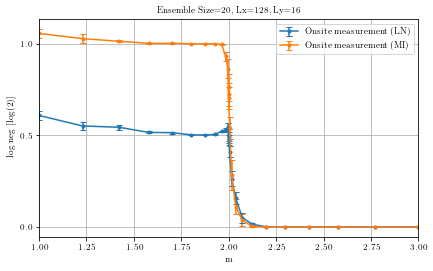

In [18]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_list.mean(axis=1)/np.log(2),LN_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_list.mean(axis=1)/np.log(2),MI_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_yticks([0,0.5,1])
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/9/LN_pSC_Born_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

In [39]:
Lx,Ly=64,4
params=Params(m=1,dxmax=Lx,dymax=Ly,Lx=np.inf,Ly=np.inf,bcx=-1,bcy=1,history=True)
total=params.linearize_index([np.arange(params.dxmax),np.arange(params.dymax)],2)
subA=params.linearize_index([np.arange(params.dxmax//4),np.arange(params.dymax)],2)
proj_range=params.linearize_index([np.arange(params.dxmax//4)+params.dxmax//4,np.arange(params.dymax)],2,proj=True)
subB=params.linearize_index([np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)],2)
params.measure_all_Born(proj_range,linear=True)


In [40]:
params.log_neg(subA,subB,linear=True)

0.00031467986715849605

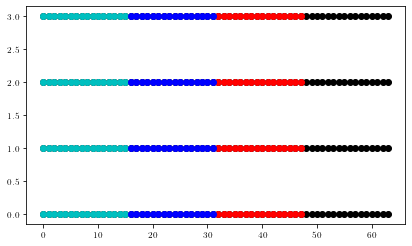

In [41]:
plt.scatter(*params.square_index(total),color='k')
plt.scatter(*params.square_index(subA),color='c')
plt.scatter(*params.square_index(subB),color='r')
plt.scatter(*params.square_index(proj_range),color='b')

In [15]:
params.C_m_history[-1][proj_range[0]:proj_range[0]+4,proj_range[0]:proj_range[0]+4]

array([[ 0., -1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  1.,  0.]])

In [49]:
run((1,128,32))

In [42]:
# m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
m_list=(np.linspace(1,3,10))
es=20
LN_Born_inf_list=np.zeros((len(m_list),es))
MI_Born_inf_list=np.zeros((len(m_list),es))
Lx,Ly=64,8

def run(p):
    m,Lx,Ly=p
    params=Params(m=m,dxmax=Lx,dymax=Ly,Lx=np.inf,Ly=np.inf,bcx=-1,bcy=1)
    total=params.linearize_index([np.arange(params.dxmax),np.arange(params.dymax)],2)
    subA=params.linearize_index([np.arange(params.dxmax//4),np.arange(params.dymax)],2)
    proj_range=params.linearize_index([np.arange(params.dxmax//4)+params.dxmax//4,np.arange(params.dymax)],2,proj=True)
    subB=params.linearize_index([np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)],2)

    params.measure_all_Born(proj_range,linear=True)
    LN=params.log_neg(subA,subB,linear=True)
    MI=params.mutual_information_m(subA,subB,linear=True)
    return MI,LN

for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born(proj_range,linear=True)
    #     MI_Born_inf_list[m_i,es_i]=params.mutual_information_m(subA,subB,linear=True)
    #     LN_Born_inf_list[m_i,es_i]=params.log_neg(subA,subB,linear=True)

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)
    for index,results in enumerate(async_result):
        MI_Born_inf_list[m_i,index],LN_Born_inf_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:26.1
1:27.6
2:26.8
3:25.1
4:24.6
5:26.9
6:25.7
7:26.0
8:26.4
9:26.4


Text(0.5, 1.0, 'Ensemble Size=20, dx=64, dy=8')

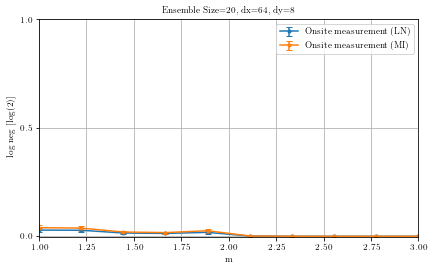

In [45]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_inf_list.mean(axis=1)/np.log(2),LN_Born_inf_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_inf_list.mean(axis=1)/np.log(2),MI_Born_inf_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_yticks([0,0.5,1])
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, dx={:d}, dy={:d}'.format(es,Lx,Ly))
# fig.savefig('/mnt/d/KITP/Rp_SPT/9/LN_pSC_Born_inf_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

# LN scaling behavior

## fix dist, |A|_x, increase |A|_y

In [1]:
LN_Ay={}

In [4]:
Ly_list=np.arange(1,16)
Lx=32
LN_Ay=[Params(m=1,Lx=Lx,Ly=Ly).log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)]) for Ly in Ly_list]


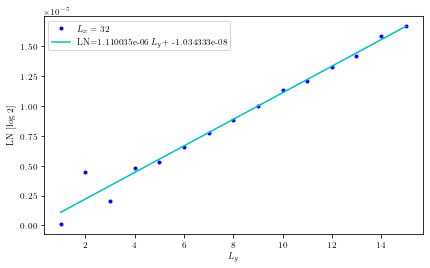

In [5]:
fig,ax=plt.subplots()
ax.plot(Ly_list,LN_Ay/np.log(2),'.',label=r'$L_x={:d}$'.format(Lx),color='b')
ax.set_xlabel(r'$L_y$')
ax.set_ylabel(r'LN [log 2]')
lr=scipy.stats.linregress(Ly_list,LN_Ay/np.log(2))
xfit=Ly_list[[0,-1]]
ax.plot(xfit,lr.slope*xfit+lr.intercept,'c',label=r'LN={:e}~$L_y$+ {:e}'.format(lr.slope,lr.intercept))

ax.legend()

# fig.savefig('//mnt/d/kitp/Rp_SPT/9/LN_Ay.pdf',bbox_inches='tight')

# After measurement

In [14]:
Ly_list=np.arange(2,16)
es=50
m=2
Lx=32
LN_Born_scaling_list=np.zeros((len(Ly_list),es))
MI_Born_scaling_list=np.zeros((len(Ly_list),es))

def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    total=params.linearize_index([np.arange(params.Lx),np.arange(params.Ly)],2)
    subA=params.linearize_index([np.arange(params.Lx//4),np.arange(params.Ly)],2)
    proj_range=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],2,proj=True)
    subB=params.linearize_index([np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)],2)

    params.measure_all_Born(proj_range,linear=True)
    LN=params.log_neg(subA,subB,linear=True)
    MI=params.mutual_information_m(subA,subB,linear=True)
    return MI,LN

for Ly_i,Ly in enumerate(Ly_list):
    st=time.time()
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)
    for index,results in enumerate(async_result):
        MI_Born_scaling_list[Ly_i,index],LN_Born_scaling_list[Ly_i,index]=results

    print('{:d}:{:.1f}'.format(Ly,time.time()-st))

2:0.3
3:0.7
4:1.4
5:2.1
6:4.2
7:6.6
8:9.3
9:11.5
10:15.8
11:20.7
12:28.7
13:34.5
14:44.6
15:56.9


In [55]:
m,es,Lx=1,20,64
# '/mnt/d/KITP/Rp_SPT/9/'
with open('/mnt/d/KITP/Rp_SPT/9/scaling_m{:d}_En{:d}_Lx{:d}.pickle'.format(m,es,Lx),'rb') as f:
    [Ly_list,MI_Born_scaling_list,LN_Born_scaling_list]=pickle.load(f)

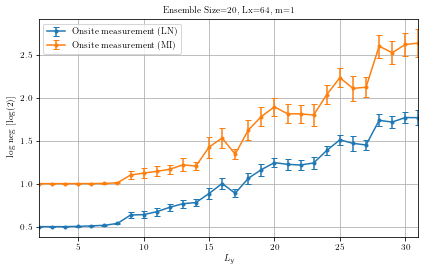

In [56]:
fig,ax=plt.subplots()
ax.errorbar(Ly_list,LN_Born_scaling_list.mean(axis=1)/np.log(2),LN_Born_scaling_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(Ly_list,MI_Born_scaling_list.mean(axis=1)/np.log(2),MI_Born_scaling_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
# ax.set_yticks([0,0.5,1])
ax.set_xlabel(r'$L_y$')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, m={:d}'.format(es,Lx,m))
fig.savefig('/mnt/d/KITP/Rp_SPT/9/scaling_m{:d}_En{:d}_Lx{:d}.pdf'.format(m,es,Lx),bbox_inches='tight')